In [3]:
! sudo apt update -y && sudo apt install -qq tesseract-ocr -y 

Get:1 http://deb.debian.org/debian bullseye InRelease [116 kB]
Get:2 https://dl.yarnpkg.com/debian stable InRelease [17.1 kB]                 
Get:3 http://deb.debian.org/debian-security bullseye-security InRelease [48.4 kB]
Get:4 http://deb.debian.org/debian bullseye-updates InRelease [44.1 kB]m
Get:5 http://deb.debian.org/debian bullseye/main amd64 Packages [8183 kB]
Get:6 https://dl.yarnpkg.com/debian stable/main all Packages [10.9 kB]
Get:7 https://dl.yarnpkg.com/debian stable/main amd64 Packages [10.9 kB]      
Get:8 http://deb.debian.org/debian-security bullseye-security/main amd64 Packages [245 kB]
Get:9 http://deb.debian.org/debian bullseye-updates/main amd64 Packages [17.5 kB]
Fetched 8692 kB in 3s (3079 kB/s)3m                       
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
6 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following additional packages will be installed:
  fontconfig libarchive13 l

In [237]:
! pip install pytesseract sentence-transformers nltk python-levenshtein matplotlib nlpaug seaborn --quiet

In [238]:
from datasets import load_dataset
from transformers import pipeline
from sentence_transformers import datasets as sent_datasets
import Levenshtein
import pytesseract
import numpy as np
import seaborn as sns
import nlpaug.augmenter.char as nac
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [261]:
ocr_kwargs: dict = dict (
  name= "OCR_Aug",
  aug_char_min= 2,
  aug_char_max= 10 ,
  aug_char_p= .3 ,
  aug_word_p= .6,
  aug_word_min= 1,
  aug_word_max= 20,
  stopwords= None,
  tokenizer= None,
  reverse_tokenizer= None,
  verbose= 0,
  stopwords_regex= None,
  min_char= 1
)

In [262]:
sample = load_dataset("lowem1/cc_news_images", split="sample")

In [263]:
row = sample[-3]

In [264]:
def process_nlp_aug(batch, col, config):
    aug = nac.OcrAug(**config)
    input_records = batch[col]
    output_records = []
    for record in input_records:
        transform = aug.augment(record)[0]
        output_records.append(transform)
    return dict(nlp_aug_text=output_records)
    
def process_ntlk_aug(batch, col):
    noise_fn = sent_datasets.DenoisingAutoEncoderDataset([]).noise_fn
    input_records = batch[col]
    output_records = []
    for record in input_records:
        transform = noise_fn(record)
        output_records.append(transform)
    return dict(tsdae_text=output_records)

def process_ocr_batch(batch, col, config="--psm 6"):
    input_records = batch[col]
    output_records = []
    for record in input_records:
        transform = pytesseract.image_to_string(image=record, config=config)
        output_records.append(transform)
    return dict(ocr_text=output_records)

def process_levenshtein_distance(batch, col1, col2, output_col=None):
    labels = batch[col1]
    output_records = []
    ocr = batch[col2]
    for s1, s2 in zip(labels, ocr):
        s1 = s1.strip("\n")
        s2 = s2.strip("\n")
        distance = Levenshtein.distance(s1, s2)
        output_records.append(distance)
    return {
        output_col: output_records
    }

def process_cardinality_distance(batch, col1, col2, output_col=None):
    labels = batch[col1]
    output_records = []
    ocr = batch[col2]
    for s1, s2 in zip(labels, ocr):
        s1_tokens = np.sort(
            np.unique(
                np.array(" ".join(s1.split("\n")).split(" "))
            )
        )
        s2_tokens = np.sort(
            np.unique(
                np.array(" ".join(s2.split("\n")).split(" "))
            )
        )
        disjoint_score = len(set(s2) - set(s1))
        output_records.append(disjoint_score)
    return {
        output_col: output_records
    }


In [283]:
sample_set = sample.select(range(200))

In [284]:

# transform_pipeline = (
#     s.select_columns(["image", "text"])
#     .map(
#         function=process_ocr_batch,
#         fn_kwargs=dict(col="image", config="psm --6"),
#         num_proc=16,
        
#         batched=True,
#         batch_size=8
#     )
# )

In [285]:
distances_report = (
    sample_set.map(
        function=process_ocr_batch,
        fn_kwargs=dict(col="image", config="--psm 6"),
        num_proc=16,
        batched=True,
        batch_size=8
    )
    .map(
        function=process_ntlk_aug,
        fn_kwargs=dict(col="text"),
        num_proc=8,
        batched=True,
        batch_size=16,
    )
    .map(
        function=process_nlp_aug,
        fn_kwargs=dict(col="text", config=ocr_kwargs),
        num_proc=8,
        batched=True,
        batch_size=16,
    )
    .map(
        function=process_levenshtein_distance,
        fn_kwargs=dict(col1="text", col2="ocr_text", output_col="comp_distance"),
        num_proc=16,
        batched=True,
        batch_size=8,
    )
    .map(
        function=process_cardinality_distance,
        fn_kwargs=dict(col1="text", col2="ocr_text", output_col="disjoint_score"),
        num_proc=16,
        batched=True,
        batch_size=8,
    )
    .map(
        function=process_levenshtein_distance,
        fn_kwargs=dict(
            col1="text", col2="tsdae_text", output_col="tsdae_comp_distance"
        ),
        num_proc=16,
        batched=True,
        batch_size=8,
    )
    .map(
        function=process_cardinality_distance,
        fn_kwargs=dict(
            col1="text", col2="tsdae_text", output_col="tsdae_disjoint_score"
        ),
        num_proc=16,
        batched=True,
        batch_size=8,
    )
        .map(
        function=process_levenshtein_distance,
        fn_kwargs=dict(
            col1="text", col2="nlp_aug_text", output_col="nlp_aug_comp_distance"
        ),
        num_proc=16,
        batched=True,
        batch_size=8,
    )
    .map(
        function=process_cardinality_distance,
        fn_kwargs=dict(
            col1="text", col2="nlp_aug_text", output_col="nlp_aug_disjoint_score"
        ),
        num_proc=16,
        batched=True,
        batch_size=8,
    )
    .select_columns(
        [
            "text",
            "ocr_text",
            "nlp_aug_text",
            "tsdae_text",
            "comp_distance",
            "disjoint_score",
            "tsdae_comp_distance",
            "tsdae_disjoint_score",
            "nlp_aug_comp_distance",
            "nlp_aug_disjoint_score",
        ]
    )
)


Map (num_proc=16):   6%|▋         | 13/200 [08:04<1:56:11, 37.28s/ examples]


TimeoutError: 

<Axes: ylabel='Density'>

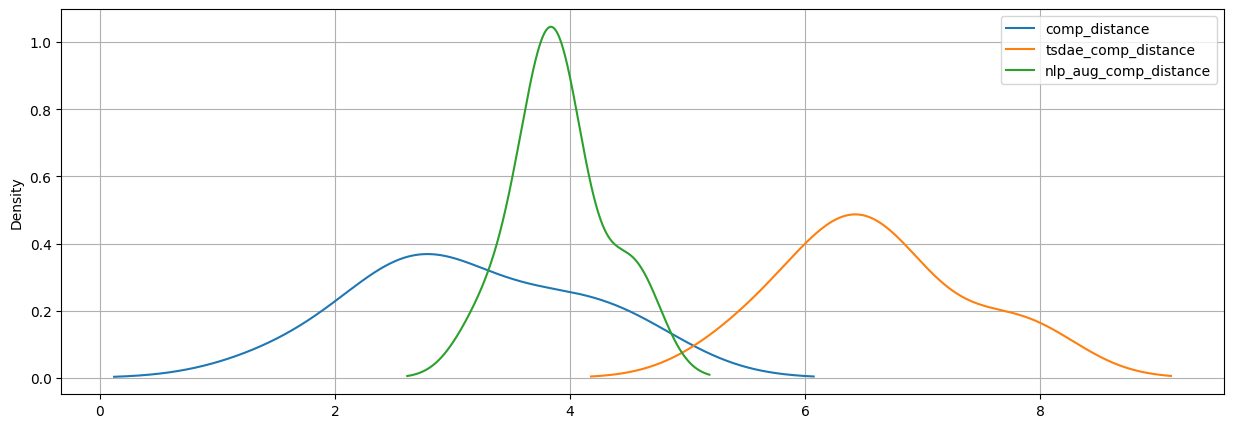

In [ ]:
(
    distances_report
    .select_columns(["comp_distance", "tsdae_comp_distance", "nlp_aug_comp_distance"])
    .to_pandas()
    .apply(np.log)
    .plot
    .density(figsize=(15,5), grid=True)
)

<Axes: ylabel='Density'>

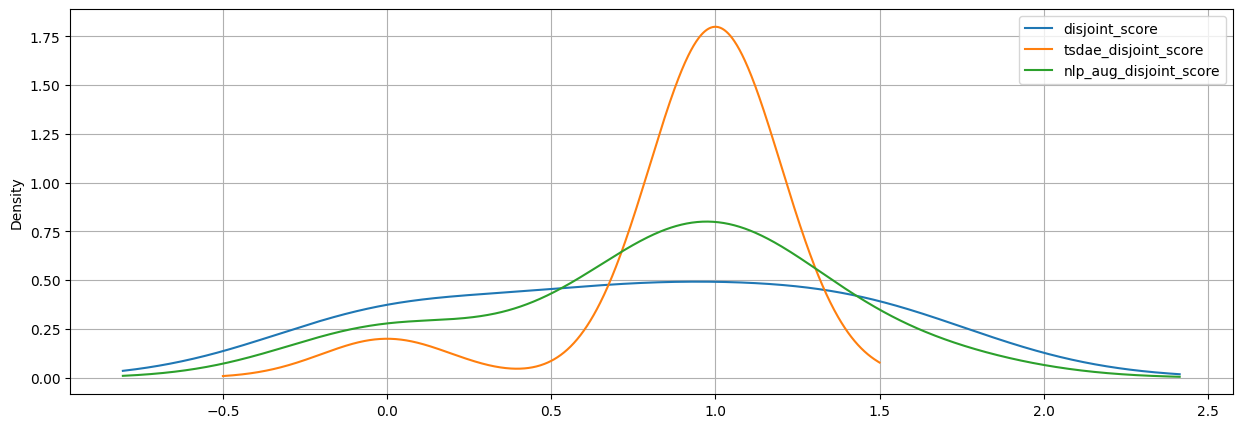

In [ ]:
(
    distances_report
    .select_columns(["disjoint_score", "tsdae_disjoint_score", "nlp_aug_disjoint_score"])
    .to_pandas()
    .apply(np.log)
    .replace([np.inf, -np.inf], 1)
    .plot
    .density(figsize=(15,5), grid=True)
)

In [282]:
distances_report.select_columns(["comp_distance", "tsdae_comp_distance", "nlp_aug_comp_distance"]).to_pandas().describe()

,comp_distance,tsdae_comp_distance,nlp_aug_comp_distance
count,10.000000,10.000000,10.000000
mean,34.100000,977.600000,53.700000
std,31.231928,840.909323,22.166291
min,5.000000,224.000000,26.000000
25%,13.000000,524.500000,42.750000
50%,17.500000,639.000000,48.500000
75%,46.250000,940.000000,53.000000
max,98.000000,2640.000000,94.000000


In [281]:
distances_report.select_columns(["disjoint_score", "tsdae_disjoint_score", "nlp_aug_disjoint_score"], ).to_pandas().describe()

,disjoint_score,tsdae_disjoint_score,nlp_aug_disjoint_score
count,10.000000,10.000000,10.000000
mean,2.500000,0.100000,1.700000
std,1.433721,0.316228,1.636392
min,1.000000,0.000000,0.000000
25%,1.250000,0.000000,0.250000
50%,2.000000,0.000000,1.500000
75%,3.750000,0.000000,2.750000
max,5.000000,1.000000,5.000000
